In [1]:
import tensorflow as tf
import scipy
import imghdr

from tensorflow.python.keras.models import load_model
from yolo_utils import *
from matplotlib.pyplot import imshow
from PIL import Image

/Users/nag/.virtualenvs/deep_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h2>Convert the output layer to bounding box</h2>

Lets explore the output layer a bit

Output layer has dimensions 19x19x425. 

<ol>
    <li>The CNN generates a 19x19 gird for determining the object location</li>
    <li>Each location in the grid will contain a values for each of the anchor box. I this case there are 5 anchor boxes of diffrent dimensions.</li>
    <li>
        Each anchor box will contain following values
        <ol>
            <li>Probability of having an object</li>
            <li>Dimensions of the bounding box. Location of the center of the box (x,y) and Dimensions of the box (width, height) (4)</li>
            <li>Class of the object in the bounding box. In this case there are 80 classes and each class is represented as a vector of size 80.</li>
        </ol>
    </li>
</ol>

Hence we have the following dimensions 19x19x(5 x (1 + 4 + 80)). Instead of representing the output layer as a 4D matrix it is computationaly simpler to just vectorize the last 2 dimensions. hence we get 19x19x425

In [2]:
def get_grid_indices(output_layer, grid):
    width_indices = tf.range(0, grid[1])
    width_indices = tf.tile(K.expand_dims(width_indices, axis=0), (grid[0], 1))
    height_indices = tf.range(0, grid[0])
    height_indices = tf.tile(K.expand_dims(height_indices, axis=0), (grid[1], 1))
    height_indices = tf.transpose(height_indices)
    indices = tf.stack([width_indices, height_indices], axis=-1)
    indices = tf.reshape(indices, (1, grid[0], grid[1], 1, 2))
    return tf.cast(indices, output_layer[0].dtype)

def unroll_boxes(output_layer, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = tf.reshape(tf.Variable(anchors), [1, 1, 1, num_anchors, 2])
    
    grid = tf.shape(output_layer)[1:3]
    
    grid_indices = get_grid_indices(output_layer, grid)

    output_layer = tf.reshape(output_layer, [-1, grid[0], grid[1], num_anchors, num_classes + 5])
    grid = tf.cast(tf.reshape(grid, [1, 1, 1, 1, 2]), output_layer.dtype)
    
    box_centers = tf.sigmoid(output_layer[...,:2])
    box_dims = tf.exp(output_layer[...,2:4])
    box_confidence = tf.sigmoid(output_layer[...,4:5])
    box_class_probs = tf.nn.softmax(output_layer[...,5:])
    
    
    box_centers = tf.divide(tf.add(box_centers, grid_indices), grid)
    box_dims = tf.divide(tf.multiply(box_dims, anchors_tensor), grid)
    
    return box_centers, box_dims, box_confidence, box_class_probs

<h1>Get box corners for drawing boxes on the image</h1>

In [3]:
def boxes_to_corners(box_centers, box_dims):
    box_mins = box_centers - (box_dims / 2.)
    box_maxes = box_centers + (box_dims / 2.)

    return tf.concat([
        box_mins[..., 1:2],
        box_mins[..., 0:1],
        box_maxes[..., 1:2],
        box_maxes[..., 0:1]
    ], axis=-1)

<h1>Filter Boxes</h1>
<p>Filter out boxes that has probabilities of conataining an object less than the threshold value</p>
<p>Filter out overlapping boxes</p>

In [4]:
import tensorflow as tf

def filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):
    box_scores = tf.multiply(box_confidence, box_class_probs)
    box_classes = tf.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    return scores, boxes, classes

In [5]:
def get_boxes(output_layer, anchors, classes, image_shape = (720., 1280.)):
    num_classes = len(classes)
    box_centers, box_dims, box_confidence, box_class_probs = unroll_boxes(output_layer, anchors, num_classes)
    boxes = boxes_to_corners(box_centers, box_dims)
    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = non_max_suppression(scores, boxes, classes)
    return  scores, boxes, classes

In [6]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data


In [7]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

In [8]:
def eval_image_2(image_file, thresholds={}):
    obj_classes = open('./coco_classes.txt', 'r').readlines()
    obj_classes = list(map(lambda cls: cls.strip(), obj_classes))
    num_classes = len(obj_classes)
    anchors = [[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]]
    colors = generate_colors(obj_classes)
    image, image_data = preprocess_image(os.path.join("images", image_file), model_image_size=(608, 608))
    image_size = image.size

    graph = load_graph('./tf_model/yolo_tf.pb')

    with graph.as_default():
        input_name = "import/" + "input_1"
        output_name = "import/" + "output_0"
        input_operation = graph.get_operation_by_name(input_name);
        output_operation = graph.get_operation_by_name(output_name);
        scores, boxes, classes = get_boxes(output_operation.outputs, anchors, obj_classes, image_shape=(float(image_size[1]), float(image_size[0])))        
        init_op = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init_op)
            [out_scores, out_boxes, out_classes] = sess.run([scores, boxes, classes], feed_dict={input_operation.outputs[0]: image_data})
            draw_boxes(image, out_scores, out_boxes, out_classes, obj_classes, colors)
            image.save(os.path.join("out", image_file), quality=90)
            output_image = scipy.misc.imread(os.path.join("out", image_file))
            imshow(output_image)
        


person 0.70 (1579, 1123) (1881, 1853)
person 0.72 (982, 1265) (1142, 1712)
person 0.77 (1148, 896) (1562, 2228)
person 0.79 (129, 999) (491, 1940)
person 0.80 (410, 827) (973, 2322)


/Users/nag/.virtualenvs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


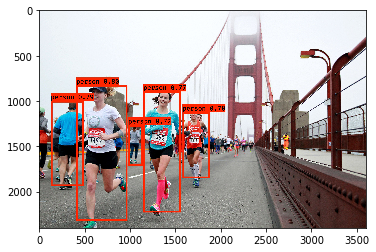

In [9]:
eval_image_2("sfmarathon.jpg")